Loaded dataset: (500, 6)
Columns: ['Drug Dosage (mg)', 'Systolic Blood Pressure (mmHg)', 'Heart Rate (BPM)', 'Liver Toxicity Index (U/L)', 'Blood Glucose Level (mg/dL)', 'Drug Response']
   Drug Dosage (mg)  Systolic Blood Pressure (mmHg)  Heart Rate (BPM)  \
0         -0.128538                        0.303280         -1.881849   
1         -1.846188                        2.865142         -0.929511   
2         -1.252393                       -1.541613          0.363632   

   Liver Toxicity Index (U/L)  Blood Glucose Level (mg/dL)  Drug Response  
0                    0.258286                    -0.792011              1  
1                    2.866786                    -0.719447              1  
2                   -0.325370                     0.191314              0  

Stat summary (numeric):
                                count      mean       std       min       25%  \
Drug Dosage (mg)                500.0 -0.037761  0.979891 -3.019512 -0.642003   
Systolic Blood Pressure (mmHg

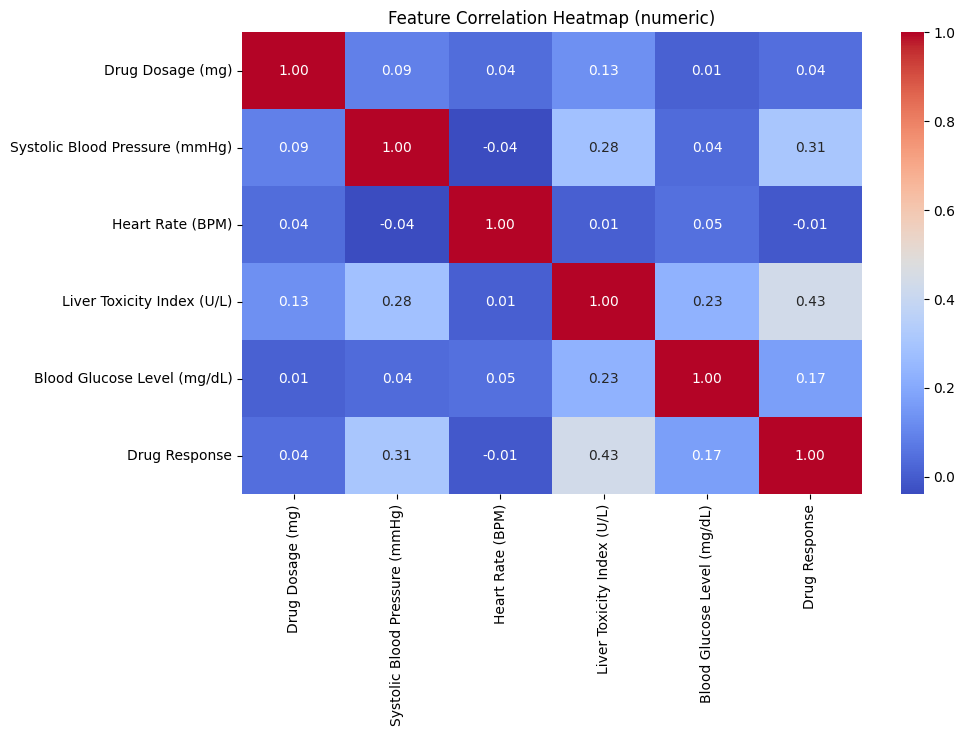


Target counts:
 Drug Response
1    260
0    240
Name: count, dtype: int64

Best params: {'svc__C': 1, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}
Best CV score (accuracy): 0.7550000000000001

Test Accuracy (best): 0.7700

Classification Report (best):
               precision    recall  f1-score   support

           0       0.77      0.75      0.76        48
           1       0.77      0.79      0.78        52

    accuracy                           0.77       100
   macro avg       0.77      0.77      0.77       100
weighted avg       0.77      0.77      0.77       100



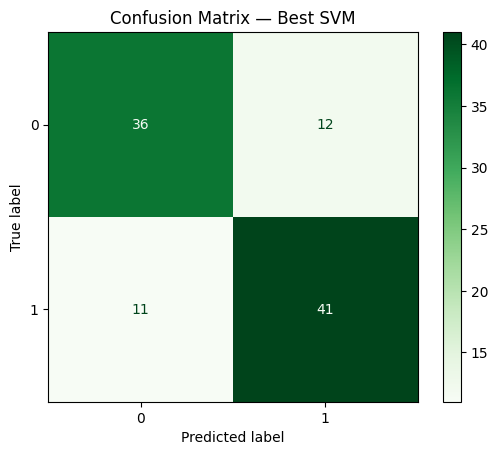

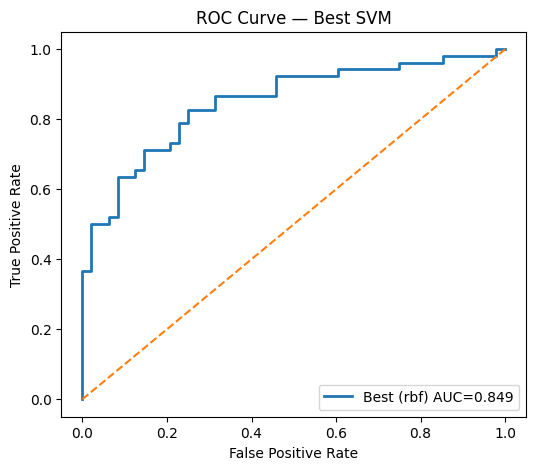

ROC AUC (best): 0.8490


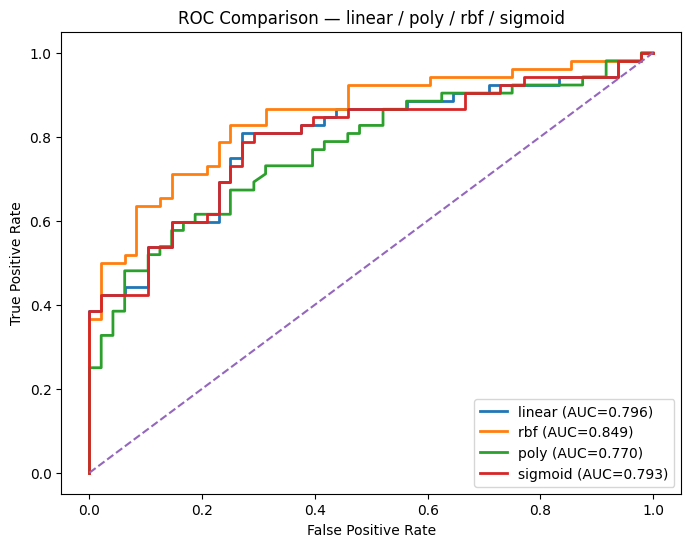


Kernel comparison (AUC & best params):
rbf       AUC=0.8490   params={'svc__C': 1, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}
linear    AUC=0.7961   params={'svc__C': 0.01, 'svc__kernel': 'linear'}
sigmoid   AUC=0.7933   params={'svc__C': 0.1, 'svc__gamma': 0.1, 'svc__kernel': 'sigmoid'}
poly      AUC=0.7698   params={'svc__C': 0.1, 'svc__degree': 3, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}


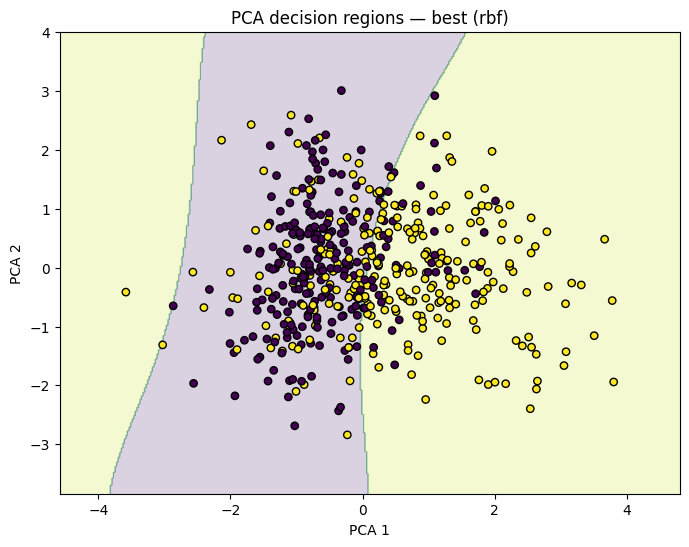


Saved deployable pipeline to model.joblib


In [4]:
# DRUG RESPONSIVE CLASSIFICATION
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    ConfusionMatrixDisplay, roc_curve, auc
)
from sklearn.decomposition import PCA
import joblib

#  CONFIG
DATA_PATH = "Pharma_Industry.csv"
TARGET_COL = "Drug Response"
RANDOM_STATE = 42
TEST_SIZE = 0.20
MODEL_OUT = "model.joblib"   # saved pipeline for deployment

#  Load
p = Path(DATA_PATH)
if not p.exists():
    raise FileNotFoundError(f"CSV not found at {DATA_PATH}. Upload the file or update DATA_PATH.")

df = pd.read_csv(p)
print("Loaded dataset:", df.shape)
print("Columns:", list(df.columns))
print(df.head(3))

#  Quick EDA
print("\nStat summary (numeric):")
print(df.select_dtypes(include=[np.number]).describe().T)

plt.figure(figsize=(10,6))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap (numeric)")
plt.show()


#  Prepare
if TARGET_COL not in df.columns:
    raise KeyError(f"Target column '{TARGET_COL}' not found. Columns: {list(df.columns)}")

X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

# Encode non-numeric target to integers if needed
if not np.issubdtype(y.dtype, np.number):
    y, target_classes = pd.factorize(y)   # y becomes int; we save classes for the app
else:
    target_classes = np.array(sorted(pd.unique(y)))

print("\nTarget counts:\n", pd.Series(y).value_counts())

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

#  Pipeline + Grids
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(random_state=RANDOM_STATE, probability=True))   # probability=True for ROC/proba
])

# kernel-specific grids
param_grid = [
    {"svc__kernel": ["linear"],  "svc__C": [0.01, 0.1, 1, 10]},
    {"svc__kernel": ["rbf"],     "svc__C": [0.1, 1, 10], "svc__gamma": ["scale", 0.1, 0.01]},
    {"svc__kernel": ["poly"],    "svc__C": [0.1, 1, 10], "svc__degree": [2, 3], "svc__gamma": ["scale", 0.1]},
    {"svc__kernel": ["sigmoid"], "svc__C": [0.1, 1, 10], "svc__gamma": ["scale", 0.1]},
]

grid = GridSearchCV(
    pipe, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0, scoring="accuracy"
)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print("\nBest params:", grid.best_params_)
print("Best CV score (accuracy):", grid.best_score_)

#  Evaluate
y_pred = best_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy (best): {acc:.4f}")
print("\nClassification Report (best):\n", classification_report(y_test, y_pred, zero_division=0))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap="Greens")
plt.title("Confusion Matrix — Best SVM")
plt.show()

# ROC for best model
probs = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, lw=2, label=f'Best ({grid.best_params_["svc__kernel"]}) AUC={roc_auc:.3f}')
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve — Best SVM')
plt.legend(loc='lower right'); plt.show()
print(f"ROC AUC (best): {roc_auc:.4f}")

#  Compare kernels
# Fit each kernel’s best combo found by GridSearch to draw combined ROC
# (GridSearch doesn't keep per-kernel best by default, so we refit small per-kernel searches.)
def per_kernel_best_roc(kernel_name, extra_params):
    grid_k = GridSearchCV(
        pipe, param_grid=[{"svc__kernel":[kernel_name], **extra_params}],
        cv=5, n_jobs=-1, scoring="accuracy", verbose=0
    )
    grid_k.fit(X_train, y_train)
    mdl = grid_k.best_estimator_
    p = mdl.predict_proba(X_test)[:,1]
    fpr_k, tpr_k, _ = roc_curve(y_test, p)
    return grid_k.best_params_, auc(fpr_k, tpr_k), fpr_k, tpr_k

kernel_param_templates = {
    "linear": {"svc__C":[0.01,0.1,1,10]},
    "rbf":    {"svc__C":[0.1,1,10], "svc__gamma":["scale",0.1,0.01]},
    "poly":   {"svc__C":[0.1,1,10], "svc__degree":[2,3], "svc__gamma":["scale",0.1]},
    "sigmoid":{"svc__C":[0.1,1,10], "svc__gamma":["scale",0.1]},
}

roc_curves = []
plt.figure(figsize=(8,6))
for k, params in kernel_param_templates.items():
    bp, auc_k, fpr_k, tpr_k = per_kernel_best_roc(k, params)
    roc_curves.append((k, auc_k, bp))
    plt.plot(fpr_k, tpr_k, lw=2, label=f"{k} (AUC={auc_k:.3f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Comparison — linear / poly / rbf / sigmoid")
plt.legend(loc="lower right"); plt.show()

print("\nKernel comparison (AUC & best params):")
for k, auc_k, bp in sorted(roc_curves, key=lambda t: t[1], reverse=True):
    print(f"{k:8s}  AUC={auc_k:.4f}   params={bp}")

#  PCA Decision Regions
def plot_svm_pca(trained_pipeline, X_df, y_arr, title):
    # project original features to 2D PCA, then refit same SVC hyperparams on PCA space for visualization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_df)
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    X2 = pca.fit_transform(X_scaled)

    svc = trained_pipeline.named_steps["svc"]
    vis = SVC(kernel=svc.kernel, C=svc.C, gamma=getattr(svc, "gamma", "scale"),
              degree=getattr(svc, "degree", 3), random_state=RANDOM_STATE)
    vis.fit(X2, y_arr)

    x_min, x_max = X2[:,0].min()-1, X2[:,0].max()+1
    y_min, y_max = X2[:,1].min()-1, X2[:,1].max()+1
    xx, yy = np.meshgrid(np.linspace(x_min,x_max,400), np.linspace(y_min,y_max,400))
    Z = vis.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.figure(figsize=(8,6))
    plt.contourf(xx, yy, Z, alpha=0.2)
    plt.scatter(X2[:,0], X2[:,1], c=y_arr, edgecolor='k', s=28)
    plt.title(title); plt.xlabel("PCA 1"); plt.ylabel("PCA 2")
    plt.show()

plot_svm_pca(best_model, pd.concat([X_train, X_test]), np.hstack([y_train, y_test]),
             title=f"PCA decision regions — best ({grid.best_params_['svc__kernel']})")

#  Save deployable model
artifact = {
    "pipeline": best_model,              # scaler + SVC inside
    "feature_names": list(X.columns),
    "target_classes": target_classes     # for label decoding if needed
}
joblib.dump(artifact, MODEL_OUT)
print(f"\nSaved deployable pipeline to {MODEL_OUT}")


In [5]:
# Write app.py
app_code = r"""
import joblib
import pandas as pd
import numpy as np
from pathlib import Path
import streamlit as st
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

st.set_page_config(page_title='Drug Response Classifier', layout='centered')
st.title('Drug Response Classifier (SVM)')

MODEL_PATH = Path('model.joblib')
DATA_PATH = Path('Pharma_Industry.csv')  # only used to get feature ranges (optional)

if not MODEL_PATH.exists():
    st.error('model.joblib not found. Run the training notebook cell to create it.')
    st.stop()

artifact = joblib.load(MODEL_PATH)
pipe = artifact['pipeline']
feature_names = artifact['feature_names']
classes = artifact['target_classes']

# Build input UI from dataset stats if available
if DATA_PATH.exists():
    df = pd.read_csv(DATA_PATH)
    # keep only features we trained on
    df = df[feature_names]
else:
    st.warning('Pharma_Industry.csv not found — using default slider ranges.')
    df = pd.DataFrame(columns=feature_names)

st.sidebar.header('Input features')
stats = df.describe().T if not df.empty else None
user_vals = {}
for col in feature_names:
    if stats is not None and col in stats.index:
        cmin = float(stats.loc[col, 'min'])
        cmax = float(stats.loc[col, '75%'] * 1.5 if not np.isnan(stats.loc[col, '75%']) else stats.loc[col, 'max'])
        cval = float(stats.loc[col, 'mean'])
        step = max((cmax - cmin) / 100, 1e-3)
    else:
        cmin, cmax, cval, step = 0.0, 1.0, 0.5, 0.01
    user_vals[col] = st.sidebar.slider(col, min_value=cmin, max_value=cmax, value=cval, step=step)

if st.sidebar.button('Predict'):
    X_user = pd.DataFrame([user_vals])[feature_names]
    proba = pipe.predict_proba(X_user)
    pred_idx = int(np.argmax(proba, axis=1)[0])
    pred_prob = float(np.max(proba, axis=1)[0])
    pred_label = classes[pred_idx] if len(classes) > pred_idx else str(pred_idx)

    st.subheader('Prediction')
    st.metric('Predicted class', str(pred_label))
    st.metric('Confidence', f'{pred_prob:.3f}')

st.markdown('---')
st.caption('Model: StandardScaler + SVC (best kernel via GridSearchCV)')
"""
with open("app.py", "w", encoding="utf-8") as f:
    f.write(app_code)
print("Wrote app.py")

# Write requirements.txt
reqs = """streamlit
pandas
numpy
scikit-learn
joblib
matplotlib
"""
with open("requirements.txt", "w") as f:
    f.write(reqs)
print("Wrote requirements.txt")


Wrote app.py
Wrote requirements.txt


In [ ]:
# In a notebook cell, this starts the dev server
# (Stop with the stop button or Ctrl+C in the cell output.)
!pip install -r requirements.txt
!streamlit run app.py


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 116.5 MB/s eta 0:00:00



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.16.82.251:8501

